In [44]:
import numpy as np
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import numpy as np
import os
import pymap3d as pm
from random import randrange
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8,8)

# Globals

In [24]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [25]:
# rotation order
rot_order = 'xyz'

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Preprocess

In [26]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position, velocity and acceleration data into single arrays
    p_gps = np.hstack((x_gps, y_gps, z_gps))
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.3
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next

    return tt_imu, lin_acc, ang_vel, q_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias


# Sensor Fusion

## Functions

In [27]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    pg_i = x_prev[19:22]
    qg_i = x_prev[22:26]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, pg_i, qg_i))
    
    return x_out

# predict the next
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((24, 24))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:24, 9:24] = np.eye(15)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((24,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx, flag):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    pg_i = x_in[19:22]
    qg_i = x_in[22:26]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    dp_i = dx[18:21]
    dtheta_i = dx[21:24]
    dq_i = euler2quat(dtheta_i, rot_order)
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    pg_i_t = pg_i + dp_i
    qg_i_t = quat_mult(qg_i, dq_i)  
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t, pg_i_t, qg_i_t))

    return x_out

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
#     print("K: ", K[3:6, :])
    
    # error
    h = get_h(x, flag)
    innov, v = get_innov(x, y_mu, h, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(24) - (K@H)) @ P
    
    return innov, dx, P, v

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_innov(x, mu, h, flag):
    if flag==0:
        inno = mu - h
        
        return inno, None
    elif flag==1:
        e = quat2euler(h)
        R = quat2matrix(h)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)

        return inno, None
    elif flag==2:
        # convert polar velocity to cartesian
        q = x[6:10]
        e = quat2euler(q)
        v_x = np.cos(e[2])*mu
        v_y = np.sin(e[2])*mu
        v_z = x[5] # we have no v_z information from radar_odometry, as it operates in 2d
        v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)
        
        inno = v_mu - h
#         print("Measurement: ", v_mu)
#         print("State: ", h)
#         print("Innovation: ", v_mu-h)
        
        return inno, v_mu
    else:
        raise

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_h(x, flag):        
    if flag == 0:
        p_t = x[0:3]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_t = x[6:10]
        q_i = x[22:26]
        
        ret = quat_mult(q_i, q_t)

        return ret

# get the full H matrix
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:24, 9:24] = np.eye(15)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu, flag):
    J1 = np.zeros((3,26))
    
    if flag==0: # position measurement
        q_i = x[22:26]
        J1[0:3, 0:3] = quat2matrix(q_i)
        J1[0:3, 19:22] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
        
    return J1

# Jacobian 2
def Jac2(x):
    q = x[6:10]
    q_i = x[22:26]
    
    J2 = np.zeros((26,24))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:22, 9:21] = np.eye(12)
    J2[22:26, 21:24] = Jac3(q_i)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

# Sample gps to test how many seconds we can go without it
def sample_gps(t_gps, p_gps, sample_rate):
    print(f"Sampling GPS every {sample_rate/10} seconds!")
    t_gpss = []
    p_gpss = []
    sample_rate = sample_rate
    for i in range(len(t_gps)):
        if i%sample_rate == 0:
            t_gpss.append(t_gps[i])
            p_gpss.append(p_gps[i])
            
    t_gpss = np.array(t_gpss)
    p_gpss = np.array(p_gpss)

    return t_gpss, p_gpss

## Loop

In [28]:
def sensor_fusion(t_gps, p_gps, 
                t_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias):
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_gps = np.array([var_p, var_p, var_p])
    var_mag = np.array([0, 0, var_w])
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_gps = var_gps*np.identity(3)
    V_mag = var_mag*np.identity(3)
    V_radar = var_radar*np.identity(3)

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    pgi0 = gps_off
    qgi0 = np.array([1, 0, 0, 0]).reshape(4,1)
    pri0 = radar_off
    qri0 = np.array([1, 0, 0, 0]).reshape(4,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pgi0, qgi0])
    dx = np.zeros((24,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    k0 = 1
    k1 = 1
    k2 = 1
    k3 = 1
    k4 = 1
    Pg_vec = np.array([var_gps[0]*k0, var_gps[1]*k0, var_gps[2]*k0, # position
                    var_v[0]*k1, var_v[1]*k1, var_v[2]*k1, # velocity
                    var_theta[0]*k2, var_theta[1]*k2, var_theta[2]*k2, # orientation
                    var_alpha[0]*k3, var_alpha[1]*k3, var_alpha[2]*k3, # lin. acc. bias
                    var_omega[0]*k4, var_omega[1]*k4, var_omega[2]*k4, # ang. velocity bias
                    1e-14, 1e-14, 1e-14, # gravity
                    1e-14, 1e-14, 1e-14,  # extrinsics - translation
                    1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
    Pg = Pg_vec*np.identity(24)
    Pg_prev = Pg

    # initialize time
    t_prev = 0
    t = 0
    dt = 0

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    GPS_flag = False 

    # counter for IMU/radar sample
    i_imu = 1
    i_gps = 1
    i = -1

    # keep the lsq timestamps
    t_lsq = []

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,24), float)
    x_list = np.empty((0,26), float)
    t_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)

    # sample GPS to see how long we can go without it
    t_gps, p_gps = sample_gps(t_gps, p_gps, sample_rate=100)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            dt = t - t_prev
                
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))
            
            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   
                
            # step 3. error state kinematics - prediction
            Pg = predict(dt, x, dx, Pg_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # gps
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a gps signal, we are in the measurement phase
        if GPS_flag:
            print("\t\t\t\t\t\t\t\tGPS signal...")
            # set time
            t = t_gps[i_gps]

            # get measurement - gps coordinates
            y_mu = p_gps[i_gps, :].reshape(3,1)

            # step 4. correction
            inno, dx, Pg, _ = correct(x, Pg, y_mu, V_gps, flag=0)
            dx_list = np.append(dx_list, dx.T, axis=0)
            innovation_list = np.append(innovation_list, inno.T, axis=0)
            
            # step 5. true state update
            x_t = true_state(x, dx, flag=0)
            
            # step 6. injection of error to nominal state
            x = x_t
            
            # step 7. ESKF reset
            dx, Pg = reset(dx, Pg)
            
            # move to the next gps signal
            i_gps+=1
            GPS_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        Pg_prev = Pg
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        gps_t = t_gps[i_gps] if i_gps < len(t_gps) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, gps_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == gps_t:
            GPS_flag = True
            
        i+=1

#         # early stop for debug
#         if i == 3000:
#             break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_gps >= len(t_gps):
            break

    print("Finito!")

    return t_list, x_list

# Visualize

In [42]:
# visualize orientation
def vis_ori(t_list, x_list, t_imu, q_imu_list):
    # convert imu orientation from quaternions to euler
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)


    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - orientation")
    plt.show()

    w_list = np.zeros((1,3))
    for i in range(1, len(t_list)):
        w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
        w_list = np.append(w_list, [w.flatten()], axis=0)

# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize position
def vis_p(t_list, x_list, t_gps, p_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=2, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=2, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=2, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r--', linewidth=2, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r--', linewidth=2, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r--', linewidth=2, label="GPS : z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, p_gps, v_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
    plt.show()

# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps):
    fig, axs = plt.subplots()

    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs GPS (every 10 secs) +IMU")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

# Main

In [30]:
# LOAD DATA
## GPS
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
## IMU
t_imu, a_imu, w_imu, q_imu, theta0_z, ab_imu, wb_imu = LoadIMU()

## make sure that all the sensor data have the same length
print("GPS, IMU shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)}")

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list] = sensor_fusion(t_gps, p_gps, 
                                 t_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu)

Loading data...
GPS, IMU shapes: 
GPS: (909,) IMU: (9035,)
Performing sensor fusion...
Sampling GPS every 10.0 seconds!
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
IMU signal...
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
IMU signal...
		Iteration #11.
IMU signal...
		Iteration #12.
IMU signal...
		Iteration #13.
IMU signal...
		Iteration #14.
IMU signal...
		Iteration #15.
IMU signal...
		Iteration #16.
IMU signal...
		Iteration #17.
IMU signal...
		Iteration #18.
IMU signal...
		Iteration #19.
IMU signal...
		Iteration #20.
IMU signal...
		Iteration #21.
IMU signal...
		Iteration #22.
IMU signal...
		Iteration #23.
IMU signal...
		Iteration #24.
IMU signal...
		Iteration #25.
IMU signal...
		Iteration #26.
IMU signal...
		Iteration #27.
IMU signal...
		Ite

		Iteration #374.
IMU signal...
		Iteration #375.
IMU signal...
		Iteration #376.
IMU signal...
		Iteration #377.
IMU signal...
		Iteration #378.
IMU signal...
		Iteration #379.
IMU signal...
		Iteration #380.
IMU signal...
		Iteration #381.
IMU signal...
		Iteration #382.
IMU signal...
		Iteration #383.
IMU signal...
		Iteration #384.
IMU signal...
		Iteration #385.
IMU signal...
		Iteration #386.
IMU signal...
		Iteration #387.
IMU signal...
		Iteration #388.
IMU signal...
		Iteration #389.
IMU signal...
		Iteration #390.
IMU signal...
		Iteration #391.
IMU signal...
		Iteration #392.
IMU signal...
		Iteration #393.
IMU signal...
		Iteration #394.
IMU signal...
		Iteration #395.
IMU signal...
		Iteration #396.
IMU signal...
		Iteration #397.
IMU signal...
		Iteration #398.
IMU signal...
		Iteration #399.
IMU signal...
		Iteration #400.
IMU signal...
		Iteration #401.
IMU signal...
		Iteration #402.
IMU signal...
		Iteration #403.
IMU signal...
		Iteration #404.
IMU signal...
		Iterat

		Iteration #740.
IMU signal...
		Iteration #741.
IMU signal...
		Iteration #742.
IMU signal...
		Iteration #743.
IMU signal...
		Iteration #744.
IMU signal...
		Iteration #745.
IMU signal...
		Iteration #746.
IMU signal...
		Iteration #747.
IMU signal...
		Iteration #748.
IMU signal...
		Iteration #749.
IMU signal...
		Iteration #750.
IMU signal...
		Iteration #751.
IMU signal...
		Iteration #752.
IMU signal...
		Iteration #753.
IMU signal...
		Iteration #754.
IMU signal...
		Iteration #755.
IMU signal...
		Iteration #756.
IMU signal...
		Iteration #757.
IMU signal...
		Iteration #758.
IMU signal...
		Iteration #759.
IMU signal...
		Iteration #760.
IMU signal...
		Iteration #761.
IMU signal...
		Iteration #762.
IMU signal...
		Iteration #763.
IMU signal...
		Iteration #764.
IMU signal...
		Iteration #765.
IMU signal...
		Iteration #766.
IMU signal...
		Iteration #767.
IMU signal...
		Iteration #768.
IMU signal...
		Iteration #769.
IMU signal...
		Iteration #770.
IMU signal...
		Iterat

		Iteration #1146.
IMU signal...
		Iteration #1147.
IMU signal...
		Iteration #1148.
IMU signal...
		Iteration #1149.
IMU signal...
		Iteration #1150.
IMU signal...
		Iteration #1151.
IMU signal...
		Iteration #1152.
IMU signal...
		Iteration #1153.
IMU signal...
		Iteration #1154.
IMU signal...
		Iteration #1155.
IMU signal...
		Iteration #1156.
IMU signal...
		Iteration #1157.
IMU signal...
		Iteration #1158.
IMU signal...
		Iteration #1159.
IMU signal...
		Iteration #1160.
IMU signal...
		Iteration #1161.
IMU signal...
		Iteration #1162.
IMU signal...
		Iteration #1163.
IMU signal...
		Iteration #1164.
IMU signal...
		Iteration #1165.
IMU signal...
		Iteration #1166.
IMU signal...
		Iteration #1167.
IMU signal...
		Iteration #1168.
IMU signal...
		Iteration #1169.
IMU signal...
		Iteration #1170.
IMU signal...
		Iteration #1171.
IMU signal...
		Iteration #1172.
IMU signal...
		Iteration #1173.
IMU signal...
		Iteration #1174.
IMU signal...
		Iteration #1175.
IMU signal...
		Iteratio

		Iteration #1510.
IMU signal...
		Iteration #1511.
IMU signal...
		Iteration #1512.
IMU signal...
		Iteration #1513.
IMU signal...
		Iteration #1514.
IMU signal...
		Iteration #1515.
IMU signal...
		Iteration #1516.
IMU signal...
		Iteration #1517.
IMU signal...
		Iteration #1518.
IMU signal...
		Iteration #1519.
IMU signal...
		Iteration #1520.
IMU signal...
		Iteration #1521.
IMU signal...
		Iteration #1522.
IMU signal...
		Iteration #1523.
IMU signal...
		Iteration #1524.
IMU signal...
		Iteration #1525.
IMU signal...
		Iteration #1526.
IMU signal...
		Iteration #1527.
IMU signal...
		Iteration #1528.
IMU signal...
		Iteration #1529.
IMU signal...
		Iteration #1530.
IMU signal...
		Iteration #1531.
IMU signal...
		Iteration #1532.
IMU signal...
		Iteration #1533.
IMU signal...
		Iteration #1534.
IMU signal...
		Iteration #1535.
IMU signal...
		Iteration #1536.
IMU signal...
		Iteration #1537.
IMU signal...
		Iteration #1538.
IMU signal...
		Iteration #1539.
IMU signal...
		Iteratio

		Iteration #1890.
IMU signal...
		Iteration #1891.
IMU signal...
		Iteration #1892.
IMU signal...
		Iteration #1893.
IMU signal...
		Iteration #1894.
IMU signal...
		Iteration #1895.
IMU signal...
		Iteration #1896.
IMU signal...
		Iteration #1897.
IMU signal...
		Iteration #1898.
IMU signal...
		Iteration #1899.
IMU signal...
		Iteration #1900.
IMU signal...
		Iteration #1901.
IMU signal...
		Iteration #1902.
IMU signal...
		Iteration #1903.
IMU signal...
		Iteration #1904.
IMU signal...
		Iteration #1905.
IMU signal...
		Iteration #1906.
IMU signal...
		Iteration #1907.
IMU signal...
		Iteration #1908.
IMU signal...
		Iteration #1909.
IMU signal...
		Iteration #1910.
IMU signal...
		Iteration #1911.
IMU signal...
		Iteration #1912.
IMU signal...
		Iteration #1913.
IMU signal...
		Iteration #1914.
IMU signal...
		Iteration #1915.
IMU signal...
		Iteration #1916.
IMU signal...
		Iteration #1917.
IMU signal...
		Iteration #1918.
IMU signal...
		Iteration #1919.
IMU signal...
		Iteratio

		Iteration #2265.
IMU signal...
		Iteration #2266.
IMU signal...
		Iteration #2267.
IMU signal...
		Iteration #2268.
IMU signal...
		Iteration #2269.
IMU signal...
		Iteration #2270.
IMU signal...
		Iteration #2271.
IMU signal...
		Iteration #2272.
IMU signal...
		Iteration #2273.
IMU signal...
		Iteration #2274.
IMU signal...
		Iteration #2275.
IMU signal...
		Iteration #2276.
IMU signal...
		Iteration #2277.
IMU signal...
		Iteration #2278.
IMU signal...
		Iteration #2279.
IMU signal...
		Iteration #2280.
IMU signal...
		Iteration #2281.
IMU signal...
		Iteration #2282.
IMU signal...
		Iteration #2283.
IMU signal...
		Iteration #2284.
IMU signal...
		Iteration #2285.
IMU signal...
		Iteration #2286.
IMU signal...
		Iteration #2287.
IMU signal...
		Iteration #2288.
IMU signal...
		Iteration #2289.
IMU signal...
		Iteration #2290.
IMU signal...
		Iteration #2291.
IMU signal...
		Iteration #2292.
IMU signal...
		Iteration #2293.
IMU signal...
		Iteration #2294.
IMU signal...
		Iteratio

		Iteration #2654.
IMU signal...
		Iteration #2655.
IMU signal...
		Iteration #2656.
IMU signal...
		Iteration #2657.
IMU signal...
		Iteration #2658.
IMU signal...
		Iteration #2659.
IMU signal...
		Iteration #2660.
IMU signal...
		Iteration #2661.
IMU signal...
		Iteration #2662.
IMU signal...
		Iteration #2663.
IMU signal...
		Iteration #2664.
IMU signal...
		Iteration #2665.
IMU signal...
		Iteration #2666.
IMU signal...
		Iteration #2667.
IMU signal...
		Iteration #2668.
IMU signal...
		Iteration #2669.
IMU signal...
		Iteration #2670.
IMU signal...
		Iteration #2671.
IMU signal...
		Iteration #2672.
IMU signal...
		Iteration #2673.
IMU signal...
		Iteration #2674.
IMU signal...
		Iteration #2675.
IMU signal...
		Iteration #2676.
IMU signal...
		Iteration #2677.
IMU signal...
		Iteration #2678.
IMU signal...
		Iteration #2679.
IMU signal...
		Iteration #2680.
IMU signal...
		Iteration #2681.
IMU signal...
		Iteration #2682.
IMU signal...
		Iteration #2683.
IMU signal...
		Iteratio

		Iteration #3036.
IMU signal...
		Iteration #3037.
IMU signal...
		Iteration #3038.
IMU signal...
		Iteration #3039.
IMU signal...
		Iteration #3040.
IMU signal...
		Iteration #3041.
IMU signal...
		Iteration #3042.
IMU signal...
		Iteration #3043.
IMU signal...
		Iteration #3044.
IMU signal...
		Iteration #3045.
IMU signal...
		Iteration #3046.
IMU signal...
		Iteration #3047.
IMU signal...
		Iteration #3048.
IMU signal...
		Iteration #3049.
IMU signal...
		Iteration #3050.
IMU signal...
		Iteration #3051.
IMU signal...
		Iteration #3052.
IMU signal...
		Iteration #3053.
IMU signal...
		Iteration #3054.
IMU signal...
		Iteration #3055.
IMU signal...
		Iteration #3056.
IMU signal...
		Iteration #3057.
IMU signal...
		Iteration #3058.
IMU signal...
		Iteration #3059.
IMU signal...
		Iteration #3060.
IMU signal...
		Iteration #3061.
IMU signal...
		Iteration #3062.
IMU signal...
		Iteration #3063.
IMU signal...
		Iteration #3064.
IMU signal...
		Iteration #3065.
IMU signal...
		Iteratio

		Iteration #3423.
IMU signal...
		Iteration #3424.
IMU signal...
		Iteration #3425.
IMU signal...
		Iteration #3426.
IMU signal...
		Iteration #3427.
IMU signal...
		Iteration #3428.
IMU signal...
		Iteration #3429.
IMU signal...
		Iteration #3430.
IMU signal...
		Iteration #3431.
IMU signal...
		Iteration #3432.
IMU signal...
		Iteration #3433.
IMU signal...
		Iteration #3434.
IMU signal...
		Iteration #3435.
IMU signal...
		Iteration #3436.
IMU signal...
		Iteration #3437.
IMU signal...
		Iteration #3438.
IMU signal...
		Iteration #3439.
IMU signal...
		Iteration #3440.
IMU signal...
		Iteration #3441.
IMU signal...
		Iteration #3442.
IMU signal...
		Iteration #3443.
IMU signal...
		Iteration #3444.
IMU signal...
		Iteration #3445.
IMU signal...
		Iteration #3446.
IMU signal...
		Iteration #3447.
IMU signal...
		Iteration #3448.
IMU signal...
		Iteration #3449.
IMU signal...
		Iteration #3450.
IMU signal...
		Iteration #3451.
IMU signal...
		Iteration #3452.
IMU signal...
		Iteratio

		Iteration #3814.
IMU signal...
		Iteration #3815.
IMU signal...
		Iteration #3816.
IMU signal...
		Iteration #3817.
IMU signal...
		Iteration #3818.
IMU signal...
		Iteration #3819.
IMU signal...
		Iteration #3820.
IMU signal...
		Iteration #3821.
IMU signal...
		Iteration #3822.
IMU signal...
		Iteration #3823.
IMU signal...
		Iteration #3824.
IMU signal...
		Iteration #3825.
IMU signal...
		Iteration #3826.
IMU signal...
		Iteration #3827.
IMU signal...
		Iteration #3828.
IMU signal...
		Iteration #3829.
IMU signal...
		Iteration #3830.
IMU signal...
		Iteration #3831.
IMU signal...
		Iteration #3832.
IMU signal...
		Iteration #3833.
IMU signal...
		Iteration #3834.
IMU signal...
		Iteration #3835.
IMU signal...
		Iteration #3836.
IMU signal...
		Iteration #3837.
IMU signal...
		Iteration #3838.
IMU signal...
		Iteration #3839.
IMU signal...
		Iteration #3840.
IMU signal...
		Iteration #3841.
IMU signal...
		Iteration #3842.
IMU signal...
		Iteration #3843.
IMU signal...
		Iteratio

		Iteration #4142.
IMU signal...
		Iteration #4143.
IMU signal...
		Iteration #4144.
IMU signal...
		Iteration #4145.
IMU signal...
		Iteration #4146.
IMU signal...
		Iteration #4147.
IMU signal...
		Iteration #4148.
IMU signal...
		Iteration #4149.
IMU signal...
		Iteration #4150.
IMU signal...
		Iteration #4151.
IMU signal...
		Iteration #4152.
IMU signal...
		Iteration #4153.
IMU signal...
		Iteration #4154.
IMU signal...
		Iteration #4155.
IMU signal...
		Iteration #4156.
IMU signal...
		Iteration #4157.
IMU signal...
		Iteration #4158.
IMU signal...
		Iteration #4159.
IMU signal...
		Iteration #4160.
IMU signal...
		Iteration #4161.
IMU signal...
		Iteration #4162.
IMU signal...
		Iteration #4163.
IMU signal...
		Iteration #4164.
IMU signal...
		Iteration #4165.
IMU signal...
		Iteration #4166.
IMU signal...
		Iteration #4167.
IMU signal...
		Iteration #4168.
IMU signal...
		Iteration #4169.
IMU signal...
		Iteration #4170.
IMU signal...
		Iteration #4171.
IMU signal...
		Iteratio

IMU signal...
		Iteration #4471.
IMU signal...
		Iteration #4472.
IMU signal...
		Iteration #4473.
IMU signal...
		Iteration #4474.
IMU signal...
		Iteration #4475.
IMU signal...
		Iteration #4476.
IMU signal...
		Iteration #4477.
IMU signal...
		Iteration #4478.
IMU signal...
		Iteration #4479.
IMU signal...
		Iteration #4480.
IMU signal...
		Iteration #4481.
IMU signal...
		Iteration #4482.
IMU signal...
		Iteration #4483.
IMU signal...
		Iteration #4484.
IMU signal...
		Iteration #4485.
IMU signal...
		Iteration #4486.
IMU signal...
		Iteration #4487.
IMU signal...
		Iteration #4488.
IMU signal...
		Iteration #4489.
IMU signal...
		Iteration #4490.
IMU signal...
		Iteration #4491.
IMU signal...
		Iteration #4492.
IMU signal...
		Iteration #4493.
IMU signal...
		Iteration #4494.
IMU signal...
		Iteration #4495.
IMU signal...
		Iteration #4496.
IMU signal...
		Iteration #4497.
IMU signal...
		Iteration #4498.
IMU signal...
		Iteration #4499.
IMU signal...
		Iteration #4500.
IMU signal

		Iteration #4797.
IMU signal...
		Iteration #4798.
IMU signal...
		Iteration #4799.
IMU signal...
		Iteration #4800.
IMU signal...
		Iteration #4801.
IMU signal...
		Iteration #4802.
IMU signal...
		Iteration #4803.
IMU signal...
		Iteration #4804.
IMU signal...
		Iteration #4805.
IMU signal...
		Iteration #4806.
IMU signal...
		Iteration #4807.
IMU signal...
		Iteration #4808.
IMU signal...
		Iteration #4809.
IMU signal...
		Iteration #4810.
IMU signal...
		Iteration #4811.
IMU signal...
		Iteration #4812.
IMU signal...
		Iteration #4813.
IMU signal...
		Iteration #4814.
IMU signal...
		Iteration #4815.
IMU signal...
		Iteration #4816.
IMU signal...
		Iteration #4817.
IMU signal...
		Iteration #4818.
IMU signal...
		Iteration #4819.
IMU signal...
		Iteration #4820.
IMU signal...
		Iteration #4821.
IMU signal...
		Iteration #4822.
IMU signal...
		Iteration #4823.
IMU signal...
		Iteration #4824.
IMU signal...
		Iteration #4825.
IMU signal...
		Iteration #4826.
IMU signal...
		Iteratio

		Iteration #5123.
IMU signal...
		Iteration #5124.
IMU signal...
		Iteration #5125.
IMU signal...
		Iteration #5126.
IMU signal...
		Iteration #5127.
IMU signal...
		Iteration #5128.
IMU signal...
		Iteration #5129.
IMU signal...
		Iteration #5130.
IMU signal...
		Iteration #5131.
IMU signal...
		Iteration #5132.
IMU signal...
		Iteration #5133.
IMU signal...
		Iteration #5134.
IMU signal...
		Iteration #5135.
IMU signal...
		Iteration #5136.
IMU signal...
		Iteration #5137.
IMU signal...
		Iteration #5138.
IMU signal...
		Iteration #5139.
IMU signal...
		Iteration #5140.
IMU signal...
		Iteration #5141.
IMU signal...
		Iteration #5142.
IMU signal...
		Iteration #5143.
IMU signal...
		Iteration #5144.
IMU signal...
		Iteration #5145.
IMU signal...
		Iteration #5146.
IMU signal...
		Iteration #5147.
IMU signal...
		Iteration #5148.
IMU signal...
		Iteration #5149.
IMU signal...
		Iteration #5150.
IMU signal...
		Iteration #5151.
IMU signal...
		Iteration #5152.
IMU signal...
		Iteratio

		Iteration #5459.
IMU signal...
		Iteration #5460.
IMU signal...
		Iteration #5461.
IMU signal...
		Iteration #5462.
IMU signal...
		Iteration #5463.
IMU signal...
		Iteration #5464.
IMU signal...
		Iteration #5465.
IMU signal...
		Iteration #5466.
IMU signal...
		Iteration #5467.
IMU signal...
		Iteration #5468.
IMU signal...
		Iteration #5469.
IMU signal...
		Iteration #5470.
IMU signal...
		Iteration #5471.
IMU signal...
		Iteration #5472.
IMU signal...
		Iteration #5473.
IMU signal...
		Iteration #5474.
IMU signal...
		Iteration #5475.
IMU signal...
		Iteration #5476.
IMU signal...
		Iteration #5477.
IMU signal...
		Iteration #5478.
IMU signal...
		Iteration #5479.
IMU signal...
		Iteration #5480.
IMU signal...
		Iteration #5481.
IMU signal...
		Iteration #5482.
IMU signal...
		Iteration #5483.
IMU signal...
		Iteration #5484.
IMU signal...
		Iteration #5485.
IMU signal...
		Iteration #5486.
IMU signal...
		Iteration #5487.
IMU signal...
		Iteration #5488.
IMU signal...
		Iteratio

		Iteration #5780.
IMU signal...
		Iteration #5781.
IMU signal...
		Iteration #5782.
IMU signal...
		Iteration #5783.
IMU signal...
		Iteration #5784.
IMU signal...
		Iteration #5785.
IMU signal...
		Iteration #5786.
IMU signal...
		Iteration #5787.
IMU signal...
		Iteration #5788.
IMU signal...
		Iteration #5789.
IMU signal...
		Iteration #5790.
IMU signal...
		Iteration #5791.
IMU signal...
		Iteration #5792.
IMU signal...
		Iteration #5793.
IMU signal...
		Iteration #5794.
IMU signal...
		Iteration #5795.
IMU signal...
		Iteration #5796.
IMU signal...
		Iteration #5797.
IMU signal...
		Iteration #5798.
IMU signal...
		Iteration #5799.
IMU signal...
		Iteration #5800.
IMU signal...
		Iteration #5801.
IMU signal...
		Iteration #5802.
IMU signal...
		Iteration #5803.
IMU signal...
		Iteration #5804.
IMU signal...
		Iteration #5805.
IMU signal...
		Iteration #5806.
IMU signal...
		Iteration #5807.
IMU signal...
		Iteration #5808.
IMU signal...
		Iteration #5809.
IMU signal...
		Iteratio

		Iteration #6116.
IMU signal...
		Iteration #6117.
IMU signal...
		Iteration #6118.
IMU signal...
		Iteration #6119.
IMU signal...
		Iteration #6120.
IMU signal...
		Iteration #6121.
IMU signal...
		Iteration #6122.
IMU signal...
		Iteration #6123.
IMU signal...
		Iteration #6124.
IMU signal...
		Iteration #6125.
IMU signal...
		Iteration #6126.
IMU signal...
		Iteration #6127.
IMU signal...
		Iteration #6128.
IMU signal...
		Iteration #6129.
IMU signal...
		Iteration #6130.
IMU signal...
		Iteration #6131.
IMU signal...
		Iteration #6132.
IMU signal...
		Iteration #6133.
IMU signal...
		Iteration #6134.
IMU signal...
		Iteration #6135.
IMU signal...
		Iteration #6136.
IMU signal...
		Iteration #6137.
IMU signal...
		Iteration #6138.
IMU signal...
		Iteration #6139.
IMU signal...
		Iteration #6140.
IMU signal...
		Iteration #6141.
IMU signal...
		Iteration #6142.
IMU signal...
		Iteration #6143.
IMU signal...
		Iteration #6144.
IMU signal...
		Iteration #6145.
IMU signal...
		Iteratio

		Iteration #6430.
IMU signal...
		Iteration #6431.
IMU signal...
		Iteration #6432.
IMU signal...
		Iteration #6433.
IMU signal...
		Iteration #6434.
IMU signal...
		Iteration #6435.
IMU signal...
		Iteration #6436.
IMU signal...
		Iteration #6437.
IMU signal...
		Iteration #6438.
IMU signal...
		Iteration #6439.
IMU signal...
		Iteration #6440.
IMU signal...
		Iteration #6441.
IMU signal...
		Iteration #6442.
IMU signal...
		Iteration #6443.
IMU signal...
		Iteration #6444.
IMU signal...
		Iteration #6445.
IMU signal...
		Iteration #6446.
IMU signal...
		Iteration #6447.
IMU signal...
		Iteration #6448.
IMU signal...
		Iteration #6449.
IMU signal...
		Iteration #6450.
IMU signal...
		Iteration #6451.
IMU signal...
		Iteration #6452.
IMU signal...
		Iteration #6453.
IMU signal...
		Iteration #6454.
IMU signal...
		Iteration #6455.
IMU signal...
		Iteration #6456.
IMU signal...
		Iteration #6457.
IMU signal...
		Iteration #6458.
IMU signal...
		Iteration #6459.
IMU signal...
		Iteratio

		Iteration #6742.
IMU signal...
		Iteration #6743.
IMU signal...
		Iteration #6744.
IMU signal...
		Iteration #6745.
IMU signal...
		Iteration #6746.
IMU signal...
		Iteration #6747.
IMU signal...
		Iteration #6748.
IMU signal...
		Iteration #6749.
IMU signal...
		Iteration #6750.
IMU signal...
		Iteration #6751.
IMU signal...
		Iteration #6752.
IMU signal...
		Iteration #6753.
IMU signal...
		Iteration #6754.
IMU signal...
		Iteration #6755.
IMU signal...
		Iteration #6756.
IMU signal...
		Iteration #6757.
IMU signal...
		Iteration #6758.
IMU signal...
		Iteration #6759.
IMU signal...
		Iteration #6760.
IMU signal...
		Iteration #6761.
IMU signal...
		Iteration #6762.
IMU signal...
		Iteration #6763.
IMU signal...
		Iteration #6764.
IMU signal...
		Iteration #6765.
IMU signal...
		Iteration #6766.
IMU signal...
		Iteration #6767.
IMU signal...
		Iteration #6768.
IMU signal...
		Iteration #6769.
IMU signal...
		Iteration #6770.
IMU signal...
		Iteration #6771.
IMU signal...
		Iteratio

		Iteration #7063.
IMU signal...
		Iteration #7064.
IMU signal...
		Iteration #7065.
IMU signal...
		Iteration #7066.
IMU signal...
		Iteration #7067.
IMU signal...
		Iteration #7068.
IMU signal...
		Iteration #7069.
IMU signal...
		Iteration #7070.
IMU signal...
		Iteration #7071.
IMU signal...
		Iteration #7072.
IMU signal...
		Iteration #7073.
IMU signal...
		Iteration #7074.
IMU signal...
		Iteration #7075.
IMU signal...
		Iteration #7076.
IMU signal...
		Iteration #7077.
IMU signal...
		Iteration #7078.
IMU signal...
		Iteration #7079.
IMU signal...
		Iteration #7080.
IMU signal...
		Iteration #7081.
IMU signal...
		Iteration #7082.
IMU signal...
		Iteration #7083.
IMU signal...
		Iteration #7084.
IMU signal...
		Iteration #7085.
IMU signal...
		Iteration #7086.
IMU signal...
		Iteration #7087.
IMU signal...
		Iteration #7088.
IMU signal...
		Iteration #7089.
IMU signal...
		Iteration #7090.
IMU signal...
		Iteration #7091.
IMU signal...
		Iteration #7092.
IMU signal...
		Iteratio

		Iteration #7382.
IMU signal...
		Iteration #7383.
IMU signal...
		Iteration #7384.
IMU signal...
		Iteration #7385.
IMU signal...
		Iteration #7386.
IMU signal...
		Iteration #7387.
IMU signal...
		Iteration #7388.
IMU signal...
		Iteration #7389.
IMU signal...
		Iteration #7390.
IMU signal...
		Iteration #7391.
IMU signal...
		Iteration #7392.
IMU signal...
		Iteration #7393.
IMU signal...
		Iteration #7394.
IMU signal...
		Iteration #7395.
IMU signal...
		Iteration #7396.
IMU signal...
		Iteration #7397.
IMU signal...
		Iteration #7398.
IMU signal...
		Iteration #7399.
IMU signal...
		Iteration #7400.
IMU signal...
		Iteration #7401.
IMU signal...
		Iteration #7402.
IMU signal...
		Iteration #7403.
IMU signal...
		Iteration #7404.
IMU signal...
		Iteration #7405.
IMU signal...
		Iteration #7406.
IMU signal...
		Iteration #7407.
IMU signal...
		Iteration #7408.
IMU signal...
		Iteration #7409.
IMU signal...
		Iteration #7410.
IMU signal...
		Iteration #7411.
IMU signal...
		Iteratio

		Iteration #7649.
IMU signal...
		Iteration #7650.
IMU signal...
		Iteration #7651.
IMU signal...
		Iteration #7652.
IMU signal...
		Iteration #7653.
IMU signal...
		Iteration #7654.
IMU signal...
		Iteration #7655.
IMU signal...
		Iteration #7656.
IMU signal...
		Iteration #7657.
IMU signal...
		Iteration #7658.
IMU signal...
		Iteration #7659.
IMU signal...
		Iteration #7660.
IMU signal...
		Iteration #7661.
IMU signal...
		Iteration #7662.
IMU signal...
		Iteration #7663.
IMU signal...
		Iteration #7664.
IMU signal...
		Iteration #7665.
IMU signal...
		Iteration #7666.
IMU signal...
		Iteration #7667.
IMU signal...
		Iteration #7668.
IMU signal...
		Iteration #7669.
IMU signal...
		Iteration #7670.
IMU signal...
		Iteration #7671.
IMU signal...
		Iteration #7672.
IMU signal...
		Iteration #7673.
IMU signal...
		Iteration #7674.
IMU signal...
		Iteration #7675.
IMU signal...
		Iteration #7676.
IMU signal...
		Iteration #7677.
IMU signal...
		Iteration #7678.
IMU signal...
		Iteratio

		Iteration #7980.
IMU signal...
		Iteration #7981.
IMU signal...
		Iteration #7982.
IMU signal...
		Iteration #7983.
IMU signal...
		Iteration #7984.
IMU signal...
		Iteration #7985.
IMU signal...
		Iteration #7986.
IMU signal...
		Iteration #7987.
IMU signal...
		Iteration #7988.
IMU signal...
		Iteration #7989.
IMU signal...
		Iteration #7990.
IMU signal...
		Iteration #7991.
IMU signal...
		Iteration #7992.
IMU signal...
		Iteration #7993.
IMU signal...
		Iteration #7994.
IMU signal...
		Iteration #7995.
IMU signal...
		Iteration #7996.
IMU signal...
		Iteration #7997.
IMU signal...
		Iteration #7998.
IMU signal...
		Iteration #7999.
IMU signal...
		Iteration #8000.
IMU signal...
		Iteration #8001.
IMU signal...
		Iteration #8002.
IMU signal...
		Iteration #8003.
IMU signal...
		Iteration #8004.
								GPS signal...
		Iteration #8005.
IMU signal...
		Iteration #8006.
IMU signal...
		Iteration #8007.
IMU signal...
		Iteration #8008.
IMU signal...
		Iteration #8009.
IMU signal...
		

		Iteration #8290.
IMU signal...
		Iteration #8291.
IMU signal...
		Iteration #8292.
IMU signal...
		Iteration #8293.
IMU signal...
		Iteration #8294.
IMU signal...
		Iteration #8295.
IMU signal...
		Iteration #8296.
IMU signal...
		Iteration #8297.
IMU signal...
		Iteration #8298.
IMU signal...
		Iteration #8299.
IMU signal...
		Iteration #8300.
IMU signal...
		Iteration #8301.
IMU signal...
		Iteration #8302.
IMU signal...
		Iteration #8303.
IMU signal...
		Iteration #8304.
IMU signal...
		Iteration #8305.
IMU signal...
		Iteration #8306.
IMU signal...
		Iteration #8307.
IMU signal...
		Iteration #8308.
IMU signal...
		Iteration #8309.
IMU signal...
		Iteration #8310.
IMU signal...
		Iteration #8311.
IMU signal...
		Iteration #8312.
IMU signal...
		Iteration #8313.
IMU signal...
		Iteration #8314.
IMU signal...
		Iteration #8315.
IMU signal...
		Iteration #8316.
IMU signal...
		Iteration #8317.
IMU signal...
		Iteration #8318.
IMU signal...
		Iteration #8319.
IMU signal...
		Iteratio

		Iteration #8597.
IMU signal...
		Iteration #8598.
IMU signal...
		Iteration #8599.
IMU signal...
		Iteration #8600.
IMU signal...
		Iteration #8601.
IMU signal...
		Iteration #8602.
IMU signal...
		Iteration #8603.
IMU signal...
		Iteration #8604.
IMU signal...
		Iteration #8605.
IMU signal...
		Iteration #8606.
IMU signal...
		Iteration #8607.
IMU signal...
		Iteration #8608.
IMU signal...
		Iteration #8609.
IMU signal...
		Iteration #8610.
IMU signal...
		Iteration #8611.
IMU signal...
		Iteration #8612.
IMU signal...
		Iteration #8613.
IMU signal...
		Iteration #8614.
IMU signal...
		Iteration #8615.
IMU signal...
		Iteration #8616.
IMU signal...
		Iteration #8617.
IMU signal...
		Iteration #8618.
IMU signal...
		Iteration #8619.
IMU signal...
		Iteration #8620.
IMU signal...
		Iteration #8621.
IMU signal...
		Iteration #8622.
IMU signal...
		Iteration #8623.
IMU signal...
		Iteration #8624.
IMU signal...
		Iteration #8625.
IMU signal...
		Iteration #8626.
IMU signal...
		Iteratio

		Iteration #8904.
IMU signal...
		Iteration #8905.
IMU signal...
		Iteration #8906.
IMU signal...
		Iteration #8907.
IMU signal...
		Iteration #8908.
IMU signal...
		Iteration #8909.
IMU signal...
		Iteration #8910.
IMU signal...
		Iteration #8911.
IMU signal...
		Iteration #8912.
IMU signal...
		Iteration #8913.
IMU signal...
		Iteration #8914.
IMU signal...
		Iteration #8915.
IMU signal...
		Iteration #8916.
IMU signal...
		Iteration #8917.
IMU signal...
		Iteration #8918.
IMU signal...
		Iteration #8919.
IMU signal...
		Iteration #8920.
IMU signal...
		Iteration #8921.
IMU signal...
		Iteration #8922.
IMU signal...
		Iteration #8923.
IMU signal...
		Iteration #8924.
IMU signal...
		Iteration #8925.
IMU signal...
		Iteration #8926.
IMU signal...
		Iteration #8927.
IMU signal...
		Iteration #8928.
IMU signal...
		Iteration #8929.
IMU signal...
		Iteration #8930.
IMU signal...
		Iteration #8931.
IMU signal...
		Iteration #8932.
IMU signal...
		Iteration #8933.
IMU signal...
		Iteratio

<IPython.core.display.Javascript object>


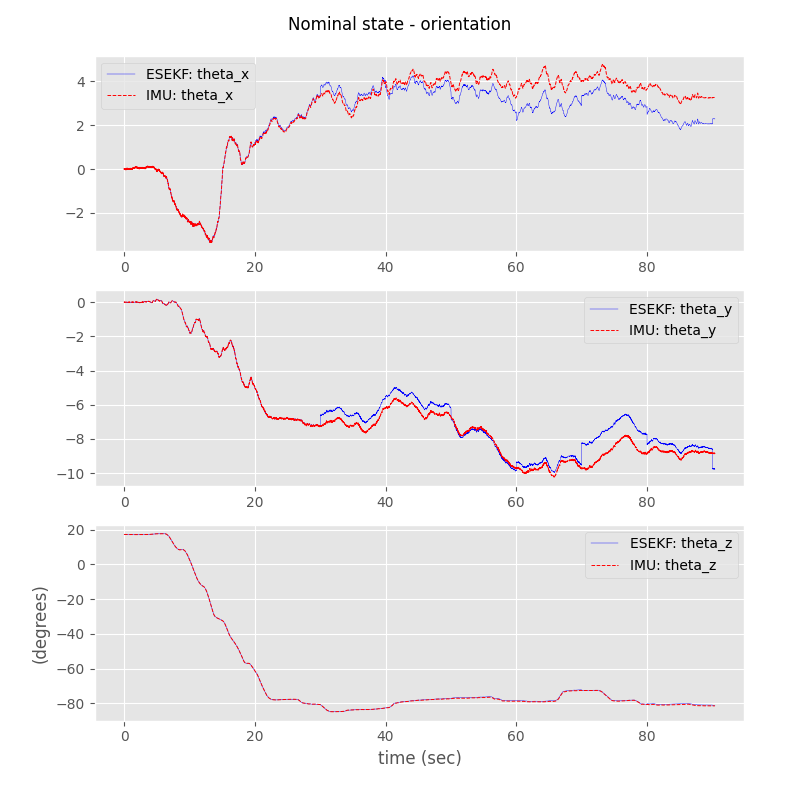

In [45]:
# vis_ori(t_list, x_list, t_imu, q_imu)

<IPython.core.display.Javascript object>


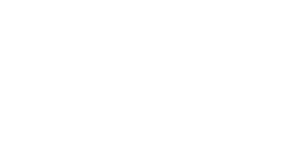

In [32]:
# vis_wb(t_list, x_list, wb_imu)

<IPython.core.display.Javascript object>


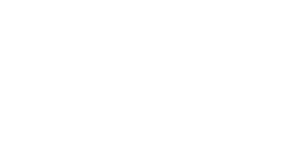

In [33]:
# vis_p(t_list, x_list, t_gps, p_gps)

<IPython.core.display.Javascript object>


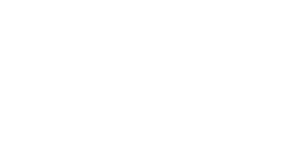

In [34]:
# vis_v(t_list, x_list, t_gps, p_gps, v_gps)

<IPython.core.display.Javascript object>


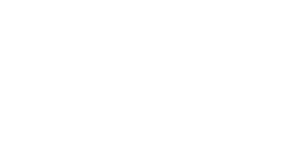

In [35]:
# vis_ab(t_list, x_list, ab_imu)

<IPython.core.display.Javascript object>


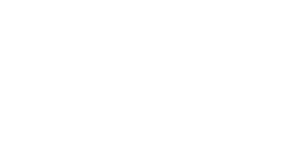

In [36]:
# vis_g(t_list, x_list)

<IPython.core.display.Javascript object>


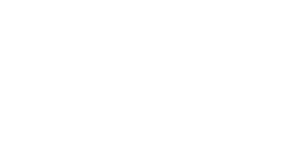

In [37]:
# vis_pi(t_list, x_list)

<IPython.core.display.Javascript object>


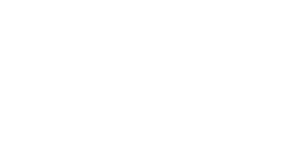

In [38]:
# vis_qi(t_list, x_list)

<IPython.core.display.Javascript object>


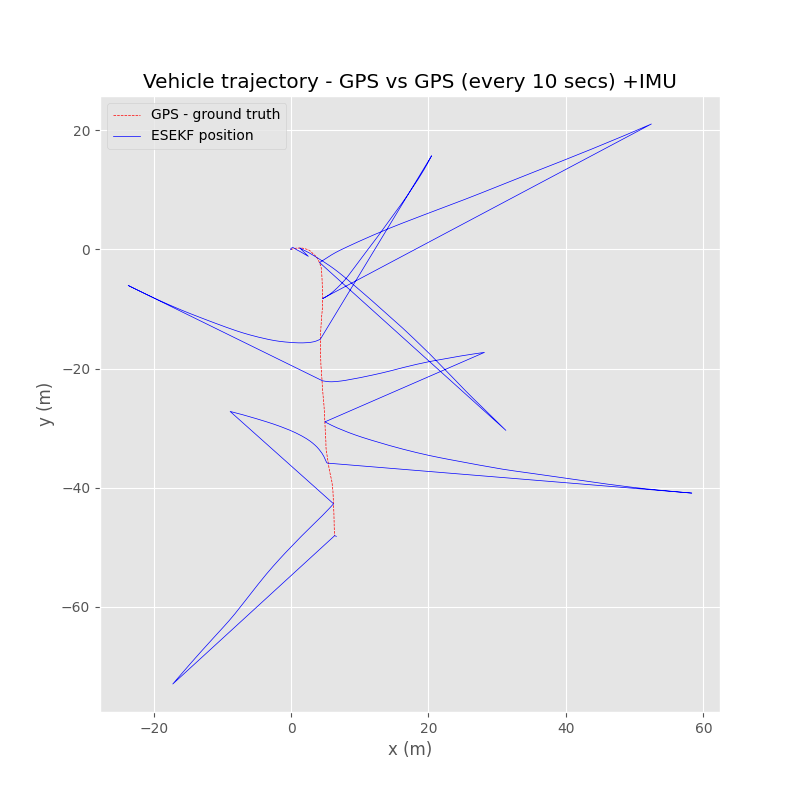

In [46]:
vis_traj_2d(x_list, p_gps)

<IPython.core.display.Javascript object>


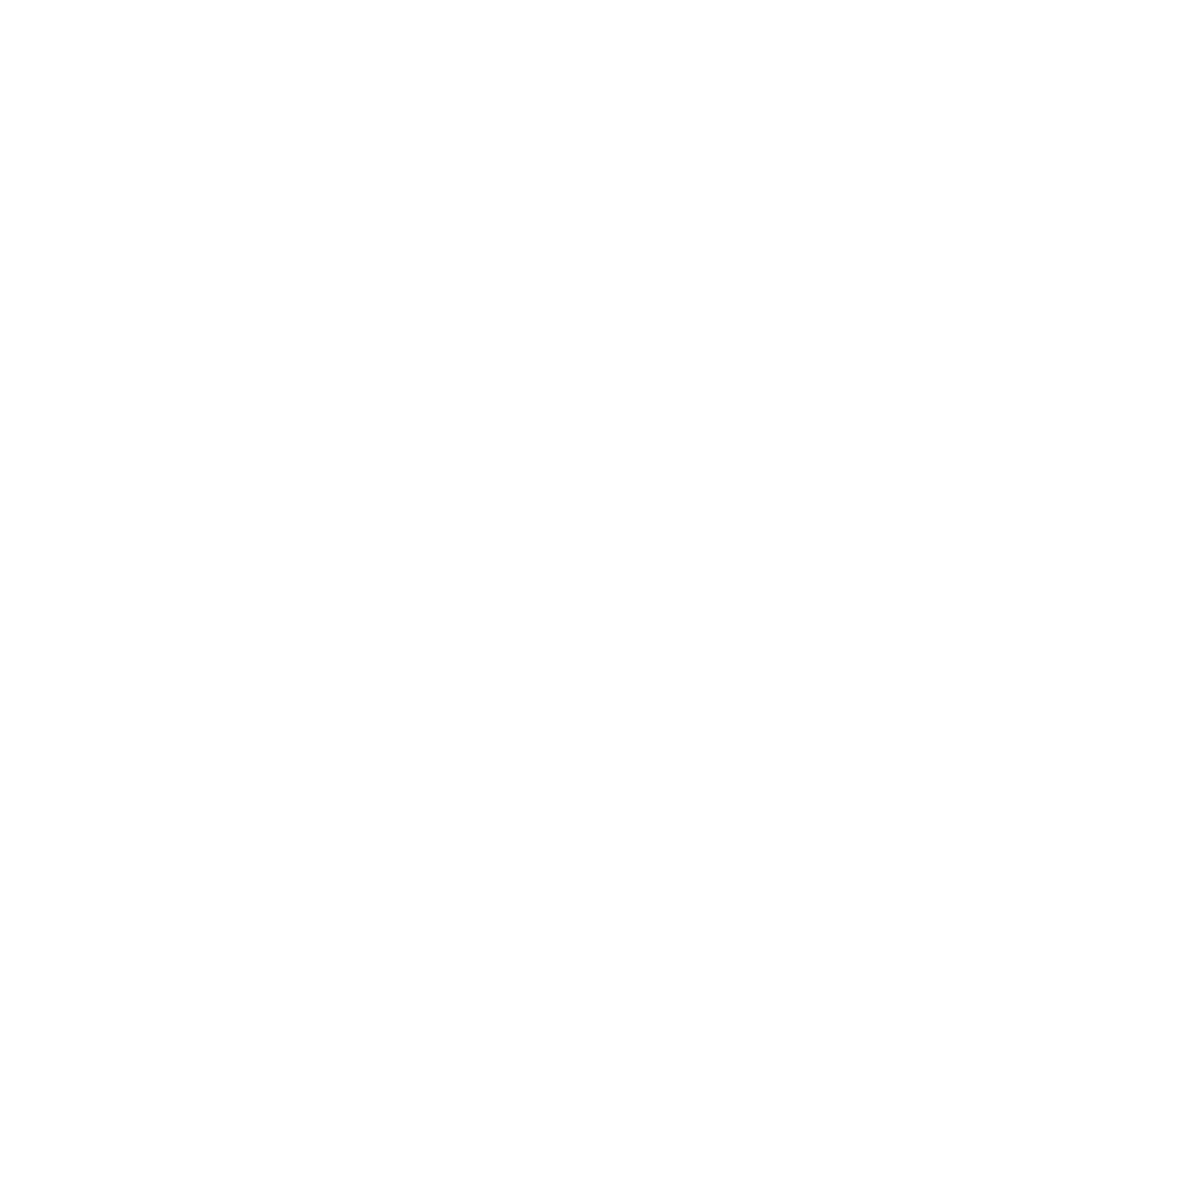

In [40]:
# vis_traj_3d(x_list, p_gps)

# The end